# LIBRARIES

In [2]:
#!/usr/bin/env python
# coding: utf-8
download_data   = False    # Download from Kaggle
generate_data   = False     # Preprocess Data. If it is false it reads the data locally.
read_from_cloud = False    # Download Preprocessed Data From Cloud. If it is false it reads the files locally.
save_to_cloud   = False    # Save to cloud. 
bucket_address  = "s3://verafin-mitacs-ruben-chevez/"
project_folder  = "customer_batches"
model_name      = "checkpoint_model.h5"
project_path    = bucket_address + project_folder 
empty_padding_value           = -1
reduce_data_for_testing       = True
reduce_data_for_testing_value = 10000

#General
import json
import zipfile
import os
import subprocess
import math
import time
import progressbar
import pickle
import joblib
import s3fs
import copy
import traceback
from pathlib import Path

#Math & Visualization
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
# get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import sklearn
from sklearn.metrics import confusion_matrix
sns.set()

import warnings
warnings.filterwarnings("ignore")

from utils import setupTF, runCommand, runCommands, downloadFromKaggle, testTry 
from models import MLModel, RNNModel
from data import downloadFromKaggle, normalizing_data, generating3DRNNInput, generateNewFeatures, separateInBatches, separateLabel, separatingTrainTest, normalize3DInput, read_data, readLocally, saveLocally, readDataFromCloud, saveToCloud  
from visualization import plot_roc_auc, pr_curve, print_confusion_matrix, visualize_data, printModelData, acc_plot, loss_plot, format_vertical_headers

print("Versions")
print("Tensorflow : ", tf.__version__)
print("Pandas     : ", pd.__version__)
print("Numpy      : ", pd.__version__) 
print("Sklearn    : ", sklearn.__version__) 

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

Versions
Tensorflow :  2.1.0
Pandas     :  1.0.3
Numpy      :  1.0.3
Sklearn    :  0.22.1


# LOAD ORIGINAL DATA

In [3]:
data, X_train, X_test, y_train, y_test, labels_hash = None, None, None, None, None, None
print("""
    DATA PREPROCESSING
    DOWNLOAD FROM KAGGLE: {}
    GENERATE DATA:        {}
    READ FROM CLOUD:      {}
    SAVE TO CLOUD:        {}
""".format(download_data, generate_data, read_from_cloud, save_to_cloud))

if(download_data):
    downloadFromKaggle(
        api_token = {"username":"rubencg195","key":"1a0667935c03c900bf8cc3b4538fa671"},
        kaggle_file_path='/home/ec2-user/.kaggle/kaggle.json',
        zip_file_path = "banksim1.zip"
    )
    
data = read_data(input_file_path="data/banksim/bs140513_032310.csv")



    DATA PREPROCESSING
    DOWNLOAD FROM KAGGLE: False
    GENERATE DATA:        False
    READ FROM CLOUD:      False
    SAVE TO CLOUD:        False



_ _ _ _ _ _ _ _ _ _  IMPORT DATA FROM CSV _ _ _ _ _ _ _ _ _ _ 


Deleting the columns 'zipcodeOri','zipMerchant' because all the fields are equal.


Data Shape: (594643, 8) 

Preview: 

    step       customer  age gender       merchant             category  amount  fraud
0  0     'C1093826151'  '4'  'M'    'M348934600'   'es_transportation'  4.55    0    
1  0     'C352968107'   '2'  'M'    'M348934600'   'es_transportation'  39.68   0    
2  0     'C2054744914'  '4'  'F'    'M1823072687'  'es_transportation'  26.89   0    
3  0     'C1760612790'  '3'  'M'    'M348934600'   'es_transportation'  17.25   0    
4  0     'C757503768'   '5'  'M'    'M348934600'   'es_transportation'  35.72   0     

 Data Information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
 #   Colu

# Data Analysis and Visualization



_ _ _ _ _ _ _ _ _ _  PIE CHART - FRAUD VS NON-FRAUD _ _ _ _ _ _ _ _ _ _ 


Total Transactions: 594643 
Total Fraud Transactions: 7200
% Safe Transactions: 98.79 
% Fraud Transactions: 1.21




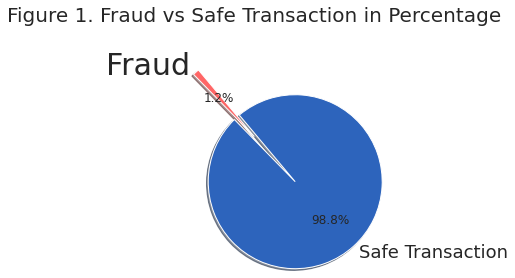



_ _ _ _ _ _ _ _ _ _  COLUMN INFORMATION & PREVIEW _ _ _ _ _ _ _ _ _ _ 



Total # of Values: 594643 
Shape: (594643, 8) 


         Parameter Nature # of Unique Entries                   Sample Entries (First three values)
step      Feature          180                 0, 1, 2                                             
customer  Feature          4112                'C1093826151', 'C352968107', 'C2054744914'          
age       Feature          8                   '4', '2', '3'                                       
gender    Feature          4                   'M', 'F', 'E'                                       
merchant  Feature          50                  'M348934600', 'M1823072687', 'M50039827'            
category  Feature          15                  'es_transportation', 'es_health', 'es_otherservices'
amount    Feature          23767               4.55, 39.68, 26.89                                  
fraud     Target           2                   0, 1                        

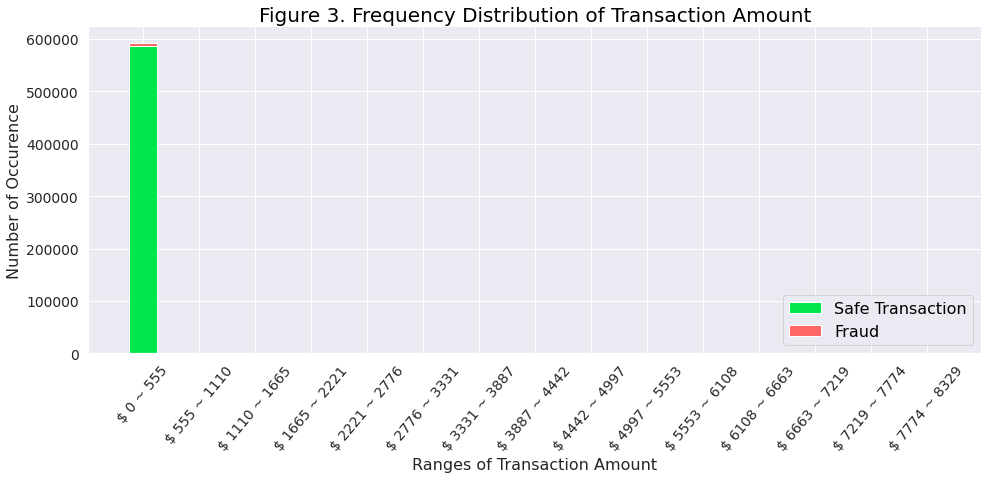



_ _ _ _ _ _ _ _ _ _  FRAUD PERCENTAGE AT DIFFERENT RANGES OF TRANSACTION AMOUNT _ _ _ _ _ _ _ _ _ _ 




<Figure size 432x432 with 0 Axes>

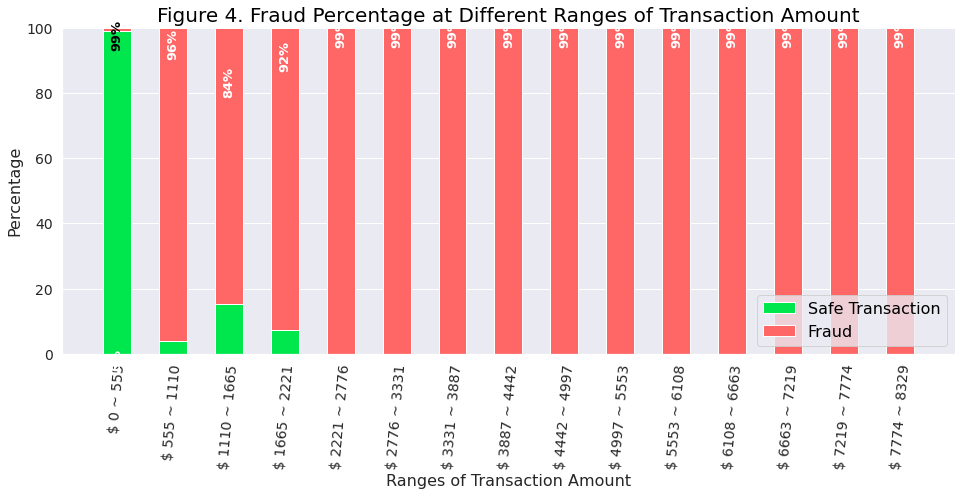



_ _ _ _ _ _ _ _ _ _  FRAUD VS NON-FRAUD HISTOGRAM _ _ _ _ _ _ _ _ _ _ 




No handles with labels found to put in legend.


<Figure size 432x432 with 0 Axes>

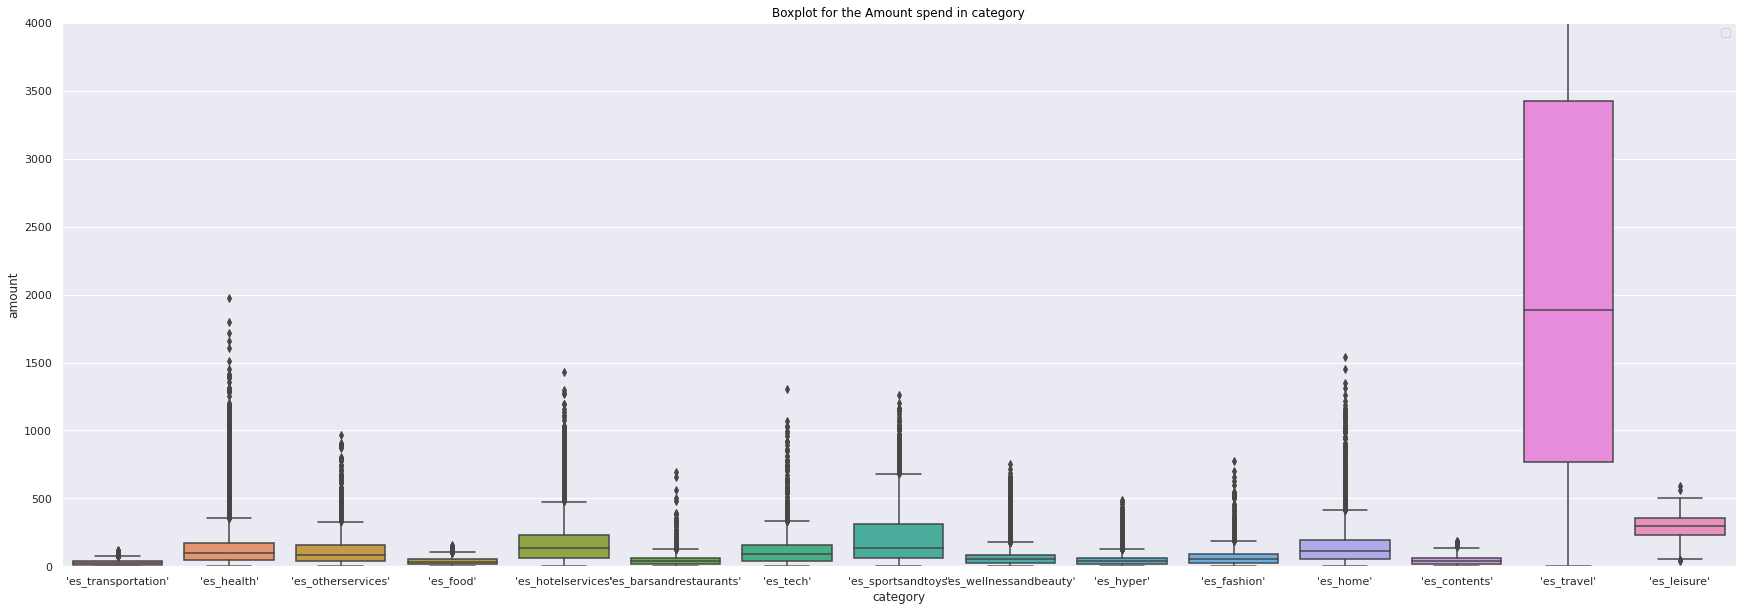



_ _ _ _ _ _ _ _ _ _  FRAUD DISTRIBUTION PER AGE _ _ _ _ _ _ _ _ _ _ 


  Age    Label  # of Fraud
1  0   <=18     48        
4  1   19-25    689       
7  2   26-35    2344      
6  3   36-45    1755      
5  4   46-55    1410      
3  5   56-65    686       
2  6   >65      261       
0  U   Unknown  7         


<Figure size 432x432 with 0 Axes>

In [4]:
visualize_data(data)

# Generating Data Hash

The hash table contains the original values of the data in case there is a need to return the processed data to its original state.



_ _ _ _ _ _ _ _ _ _  CATEGORICAL VALUES TO NUMERICAL - HASHMAP GENERATION _ _ _ _ _ _ _ _ _ _ 


Features Types: 

step        int64  
customer    object 
age         object 
gender      object 
merchant    object 
category    object 
amount      float64
fraud       int64  
dtype: object


Categorical Features: Index(['customer', 'age', 'gender', 'merchant', 'category'], dtype='object')



Hash maps previews:

__________ customer __________ 
    Index          Label
0  210    'C1093826151'
1  2753   'C352968107' 
2  2285   'C2054744914'
3  1650   'C1760612790'
4  3585   'C757503768' 
__________ age __________ 
    Index Label
0  4      '4' 
1  2      '2' 
3  3      '3' 
4  5      '5' 
6  1      '1' 
__________ gender __________ 
      Index Label
0    2      'M' 
2    1      'F' 
467  0      'E' 
586  3      'U' 
__________ merchant __________ 
     Index          Label
0   30     'M348934600' 
2   18     'M1823072687'
12  36     'M50039827'  
40  22     'M1888755466'
42  0      'M10

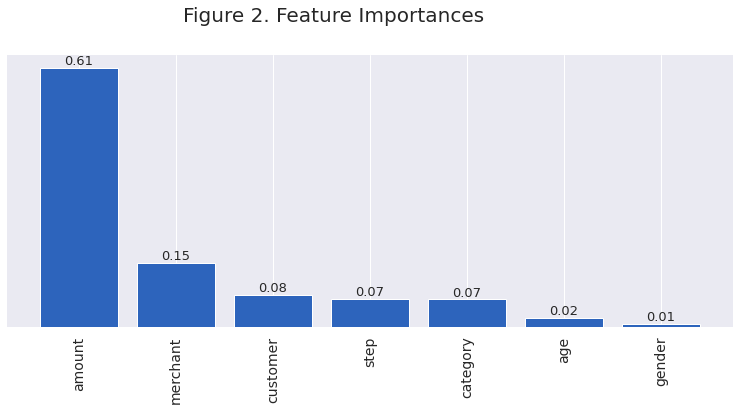

<Figure size 432x288 with 0 Axes>

In [4]:
labels_hash                        = normalizing_data(data)

# Generate 3D Customer Batches



_ _ _ _ _ _ _ _ _ _  VISUALIZATION BEFORE TRANSFORMATION _ _ _ _ _ _ _ _ _ _ 


Total Fraud vs Non-Fraud Transactions Count: 

0    587443
1    7200  
Name: fraud, dtype: int64

Number of customers:  4112
Ratio of positive frauds vs total dataset: 1.21%

Transactions per customer.
	Mean: 144.6
	Max:  265 
	Number of Batches Using Max Amount as Fixed Size: 2243.9 ~ 2244
	Number of Batches Using Mean Amount as Fixed Size: 4112.0 ~ 4112


Samples per Step (day): 
	Mean: 3304 
	Max: 3774 
	Number of Batches Using Max Amount as Fixed Size: 157.6 ~ 158
	Number of Batches Using Mean Amount as Fixed Size: 180.0 ~ 180


_ _ _ _ _ _ _ _ _ _  GROUPING TRANSACTIONS BY CUSTOMER ID _ _ _ _ _ _ _ _ _ _ 


LEN:  4112
# Feaures:  8
MIN TRANS PER CUST:  5
MEAN TRANS PER CUST:  144.61162451361866  ~  145
MAX TRANS PER CUST:  265
EXAMPLE: 

         step  customer  age  gender  merchant  category  amount  fraud
80563   30    0         5    2       22        9         143.87  0    
105386  38    0       

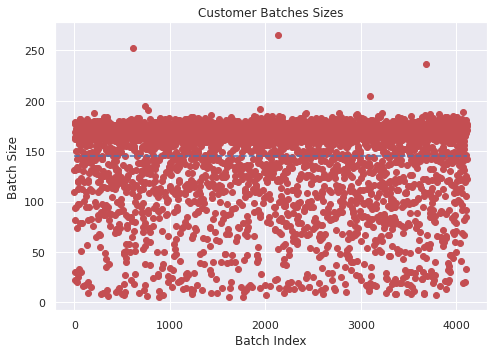



BOX PLOT SHOWING MEAN SIZE OF BATCHES GROUPED BY CUSTOMER ID: 




<Figure size 432x288 with 0 Axes>

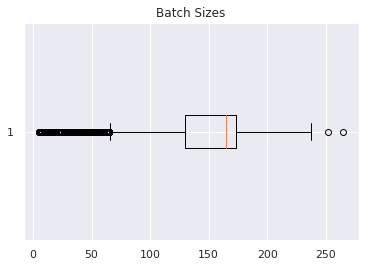

N/A% (0 of 4112) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--



_ _ _ _ _ _ _ _ _ _  GENERATING 3D INPUT WITH BATCHES OF SIZE 265 _ _ _ _ _ _ _ _ _ _ 




 11% (469 of 4112) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01


        The batches are separated by customer id. To be able to use the batches as input for the RNN, 
        it needs to have a static size. That is why the batch size is defined by the max number of 
        transactions done by the customers (265). If one of the customers have done less transactions,
        the rest of the empty space is filled with -1 values. The final array size is (4112, 265, 8).

 
Total Empty Rows Added:  495037 
Percentage of Empty Rows Added Compared to Total # of Data Points: % 45.43 
New Shape:  (4112, 265, 8) 
Mean of frauds per batch:  0.00024 
Percentage of frauds per batch:  9e-05


_ _ _ _ _ _ _ _ _ _  GENERATING 3D INPUT WITH BATCHES OF SIZE 145 _ _ _ _ _ _ _ _ _ _ 




 97% (4008 of 4112) |################### | Elapsed Time: 0:00:02 ETA:   0:00:00


      The batches are separated by customer id. To be able to use the batches as input for the RNN, 
      it needs to have a static size. That is why the batch size is defined by the average number of 
      transactions done by the customers (145). If one of the customers have done less transactions,
      the rest of the empty space is filled with -1 values. The final array size is (4575, 145, 8). The difference
      between this new more compacted version than previous which uses the max amount of transactions
      per customers is that if a customer has more than the average number of transactions, these 
      transactions are saved in a separate array called left_overs. The left overs are then shaped as
      a 3D array and appended to the main array. The problem with this array which is more efficient in 
      space and has less empty rows is that the mayority of batches are arranged by customer ID but the
      last batches are in disorder, having transactions from many cu

<Figure size 432x288 with 0 Axes>

In [5]:
rnn_data, smaller_batches_rnn_data = generating3DRNNInput(data)

# Create New Fratures

In [ ]:
rnn_mod_data                       = generateNewFeatures(rnn_data)



_ _ _ _ _ _ _ _ _ _  GENERATING NEW FEATURES _ _ _ _ _ _ _ _ _ _ 



        The following features will created using the original Data. 
        The data generated is calculated inside each batch or group
        or transactions grouped by custmer ID. Each calculation takes
        all the data points before the current transaction in which the
        loop index is currently located.

        	 Current day number of transactions  - "curr_day_tr_n"
        	 Average transaction amount per day  - "ave_tr_p_day_amount"
        	 Total average transaction amount 
        	 From the beggining to current time  - "tot_ave_tr_amount"
        	 Is the merchant new?                - "is_mer_new"
        	 What is the common transaction type - "com_tr_type"
        	 What is the common merchant ID      - "com_mer"
        


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  




 17% (728 of 4112) |###                  | Elapsed Time: 0:12:41 ETA:   0:59:06

# Separate in Smaller Batches Using Sliding Window

In [ ]:
X, grouped_X, y, grouped_y         = separateInBatches(rnn_mod_data, min_batch_size=25)

# Normalize Data

In [ ]:
X_norm                             = normalize3DInput(X)
# Delete -1 Padding
y[y==empty_padding_value] = 0

# Creating Train, Test, Validation Split

In [ ]:
X_train, X_test, y_train, y_test, X_val, y_val = separatingTrainTest(X_norm, y)

# Save To Drive

In [ ]:
saveLocally(
    rnn_data, rnn_mod_data, 
    X_train, y_train, X_test, 
    y_test, X_val, y_val, labels_hash
)